In [ ]:
from dotenv import dotenv_values
import os
from pymongo import MongoClient
from langchain_openai import OpenAIEmbeddings, OpenAI
from langchain_community.vectorstores import MongoDBAtlasVectorSearch
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import ChatPromptTemplate
from operator import itemgetter
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List
from langchain.output_parsers.openai_tools import JsonOutputKeyToolsParser
from bson.objectid import ObjectId

config = dotenv_values('.env')

os.environ['LANGCHAIN_TRACING_V2'] = config.get('LANGCHAIN_TRACING_V2')
os.environ['LANGCHAIN_ENDPOINT'] = config.get('LANGCHAIN_ENDPOINT')
os.environ['LANGCHAIN_API_KEY'] = config.get('LANGCHAIN_API_KEY')
os.environ['OPENAI_API_KEY'] = config.get('OPENAI_API_KEY')
os.environ["LANGCHAIN_PROJECT"] = 'POC'


# dynamically define roles in a team

In [14]:
roles = ['Business Analyst', 'Software developer', 'Quality Engineer', 'Product designer']


def gen_relationship(roles):
    # find all pairs of roles in the list
    relationships = []
    for i in range(len(roles)):
        for j in range(i+1, len(roles)):
            relationships.append((roles[i], roles[j]))
            relationships.append((roles[j], roles[i]))
    return relationships


# Generate relationship graph 

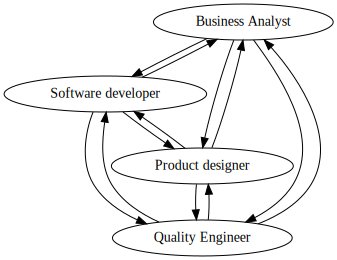

In [15]:
import graphviz
from IPython.display import display
graph = graphviz.Digraph()

relationships = gen_relationship(roles)
for r in relationships:
    graph.edge(r[0], r[1])

# Display the graph inline in the notebook
display(graph)

In [23]:
from openai import OpenAI

def prompt_generator(digest_role, feeder_role):
  prompt = f"""You are an expert in creating high quality task description, you task is to create a 
  task description for a digital AI assistant. You will be given 2 roles, one called digestion role, and the other called feeder role.
  possible following certain skillset with this role, and the feeder role's name, possible following certain skillset with that role.
  and then you need to gnenerate a task description for the AI assistant to help the digestion role to understand the action and impact of the feeder role.
  the prompt you generated will be fed into the llm model to run critical analysis on the action and impact of the feeder role to the digestion role.

  I will give you examples prompt followed by explaination of the prompt.

  Example1: digistion role: Business Analyst, and the feeder role: Software developer. Example is delimited by triple quotes:\"\"\"

  You are a great technical and business analysis leader with good understanding of coding technology and also very converse in translating technical development, design and code changes into business analyst who
  is not strong in detials of tech implementation , but mainly responsible for understanding the requirement gathering and analysis, Stakeholder communication, Process modeling,  Solution assessment and validation. You have now received an activity summary from a developer,
  in json format, that contains the following information: $feeder_activities. Based on the activity you have completed recently in json format: $digestion_activities. 
  Identify any key update you can pick up from the developer's activity and how it impacts your work as a business analyst. \"\"\"

  Explaination to the above example: .

  Example 2: Digiestion role name: Business Analyst, and the feeder role name: Product designer, example is delimited by triple quotes:\"\"\"

  You are a great technical and business analysis leader with excellent skills in translating design concepts and updates into actionable business insights. You have a solid understanding of design principles, aesthetics, and user experience, and you are proficient in capturing and analyzing requirements, stakeholder communication, process modeling, and solution assessment and validation. 
  You have now received an activity summary from a Product Designer, in JSON format, containing the following information: $feeder_activities. Based on the activities you have completed recently, in JSON format: $digestion_activities. 
  Identify any key updates you can pick up from the Product Designer's activity and how these updates impact your work as a Business Analyst. Focus on understanding:
  1. Any new design changes or iterations that have been made.
  2. How these design updates impact the business requirements or user stories.
  3. Any potential adjustments needed in the process models or solution assessments.
  4. How stakeholder communication needs to be managed or updated based on the new design changes.
  5. Any validation steps required to ensure the design aligns with the business goals and requirements.\"\"\"

  Example 3: Digiestion role name: Software Tester, and the feeder role name: Software Developer, example is delimited by triple quotes:\"\"\"
  You are an exceptional Software Tester with a solid understanding of coding technology and excellent skills in translating development activities and code updates into comprehensive testing scenarios and plans. As a Software Tester, you are primarily responsible for creating detailed test cases, executing tests, reporting on issues, ensuring quality assurance, and validating solution outcomes. 

  You have now received an activity summary from a Software Developer, in JSON format, containing the following information: $feeder_activities. Based on the activities you have completed yesterday, in JSON format: $digestion_activities. 

  Identify any key updates you can pick up from the developer's activity and how these updates impact your work as a Software Tester. Focus on understanding:

  1. Any new features, functionalities, or code changes that have been implemented.
  2. How these development updates impact your existing test cases or require the creation of new test cases.
  3. Any adjustments needed in your test execution plans to accommodate the new or modified functionalities.
  4. Any bugs or issues reported in your previous testing that may have been addressed by the developer's updates.
  5. How you need to manage communication with stakeholders or other team members based on these latest development activities.
  6. Any validation steps required to ensure the new code meets the expected quality standards and business requirements.\"\"\"

  Make sure to integrate this analysis towards enhancing your testing strategy and ensuring high-quality deliverables.

  Note: $feeder_activities and $digestion_activities is a placeholder in the task description and you must those 2 in the correct place in your task description generation
  You are given the digistion role name: {digest_role}, and the feeder role name: {feeder_role}
  """
  client = OpenAI()

  completion = client.chat.completions.create(
    model="gpt-4o",
    messages=[
      {"role": "system", "content": prompt}
    ]
  )
  return completion.choices[0].message.content


# Generate prompts for all relationship

In [24]:
# create a pandas dataframe with 3 columns: digestion_role, feeder_role, and prompt
import pandas as pd
df = pd.DataFrame(columns=['digestion_role', 'feeder_role', 'prompt'])
data = []

for r in relationships:
    data.append({'digestion_role': r[0], 'feeder_role': r[1], 'prompt': prompt_generator(r[0], r[1])})

df = pd.DataFrame(data, columns=['digestion_role', 'feeder_role', 'prompt'])



## Simulate Business Anaylst activities


Generate a meeting notes for a business analyst who discussed a regulatory reporting use cases with key stakeholders regarding manage different level of access, permission, approval in reviewing reports and a data preparation process. Discuss some of the data retention period with business user.
Participants are: 
Business Analyst: Busniess Analyst
Head of Compliance: Mark Davis
Business User (Finance Department): Emma Wilson


Problem:

When developer code review completes, Notify Quality engineer for testing.
When "Unpredicted" change raised. (Developer made, Customer urgent request)
Jira & document not changed
Test don't get updated.


### Simulated Event format:

{
    "platform": "meeting",
    "activity": "Meeting Summary:\n    1. Regulatory Reporting Use Cases\n    Busniess Analyst provided an overview of the regulatory reporting requirements and the critical use cases to ensure compliance.\n    Mark Davis emphasized the necessity to meet all regulatory standards to maintain transparency and avoid penalties.\nEmma Wilson discussed the current reporting processes within the Finance Department and highlighted some areas needing improvement.\n2. Access, Permissions, and Approvals\nBusniess Analyst outlined the need for different levels of access and permissions to manage reports effectively:\n\nAdmin Access: Full control over report creation, editing, and user permissions management.\nReviewer Access: Permission to review and approve reports without editing capabilities.\nViewer Access: Read-only access for viewing reports without making changes.\nMark Davis suggested implementing a role-based access control (RBAC) system to streamline the management of permissions and ensure security.\n\nEmma Wilson agreed on the need for a clear approval workflow to ensure timely and accurate report reviews.\n\n3. Data Preparation Process\nEmma Wilson described the current data preparation process:\n\nData Collection: Gathering data from various sources.\nData Cleansing: Removing duplicates and correcting inaccuracies.\nData Transformation: Formatting data to meet regulatory reporting standards.\nBusniess Analyst recommended adopting ETL (Extract, Transform, Load) tools to automate data preparation and improve efficiency.\n\nMark Davis highlighted the importance of maintaining data integrity throughout the preparation process.\n\n4. Data Retention Period Discussion\nMark Davis outlined regulatory requirements for data retention, emphasizing compliance with legal mandates.\n\nEmma Wilson discussed the business requirements for retaining financial data for internal analysis and audits.\n\nDiscussion Points:\n\nRegulatory Compliance: Ensuring data is retained for the legally required period (e.g., 7 years).\nBusiness Needs: Retaining data beyond regulatory requirements for historical analysis and trend reporting.\nData Archiving: Implementing a data archiving solution to manage and access older data efficiently.\nBusniess Analyst proposed developing a comprehensive data retention policy that balances regulatory and business needs, including:\n\nDefining retention periods for different types of data.\nEstablishing procedures for archiving and purging data.\nEnsuring secure storage and easy retrieval of archived data.\nAction Items:\nBusniess Analyst: Draft detailed use cases and requirements for regulatory reporting.\nMark Davis: Compile and share regulatory requirements for data retention with the team.\nEmma Wilson: Provide detailed documentation of the current data preparation process.\n Busniess Analyst: Create a draft data retention policy for review by all stakeholders.",
    "attendess": ["Busniess Analyst", "Stake holder1", "Stake holder 2"]
}

{
    "platform": "jira",
    "activity": {
        "user_story": ""
    }
}

{
    "platform": "confluence",
    "activity": {
        "feature_xxxx": ""
    }
}




In [ ]:
# Business Analyst, Process -> Feature -> Create userflow | UX, requirements
# 
# QA: Jira ticket -> Test case -> Test plan
#  

In [ ]:
from openai import OpenAI

def prompt_generator(digest_role, feeder_role):
  prompt = f"""You are an expert in creating high quality task description, you task is to create a 
  task description for a digital AI assistant. You will be given 2 roles, one called digestion role, and the other called feeder role.
  possible following certain skillset with this role, and the feeder role's name, possible following certain skillset with that role.
  and then you need to gnenerate a task description for the AI assistant to help the digestion role to understand the action and impact of the feeder role.
  the prompt you generated will be fed into the llm model to run critical analysis on the action and impact of the feeder role to the digestion role.

  I will give you examples prompt followed by explaination of the prompt.

  Example1: digistion role: Business Analyst, and the feeder role: Software developer. Example is delimited by triple quotes:\"\"\"

  You are a great technical and business analysis leader with good understanding of coding technology and also very converse in translating technical development, design and code changes into business analyst who
  is not strong in detials of tech implementation , but mainly responsible for understanding the requirement gathering and analysis, Stakeholder communication, Process modeling,  Solution assessment and validation. You have now received an activity summary from a developer,
  in json format, that contains the following information: $feeder_activities. Based on the activity you have completed recently in json format: $digestion_activities. 
  Identify any key update you can pick up from the developer's activity and how it impacts your work as a business analyst. \"\"\"

  Explaination to the above example: .

  Example 2: Digiestion role name: Business Analyst, and the feeder role name: Product designer, example is delimited by triple quotes:\"\"\"

  You are a great technical and business analysis leader with excellent skills in translating design concepts and updates into actionable business insights. You have a solid understanding of design principles, aesthetics, and user experience, and you are proficient in capturing and analyzing requirements, stakeholder communication, process modeling, and solution assessment and validation. 
  You have now received an activity summary from a Product Designer, in JSON format, containing the following information: $feeder_activities. Based on the activities you have completed recently, in JSON format: $digestion_activities. 
  Identify any key updates you can pick up from the Product Designer's activity and how these updates impact your work as a Business Analyst. Focus on understanding:
  1. Any new design changes or iterations that have been made.
  2. How these design updates impact the business requirements or user stories.
  3. Any potential adjustments needed in the process models or solution assessments.
  4. How stakeholder communication needs to be managed or updated based on the new design changes.
  5. Any validation steps required to ensure the design aligns with the business goals and requirements.\"\"\"

  Example 3: Digiestion role name: Software Tester, and the feeder role name: Software Developer, example is delimited by triple quotes:\"\"\"
  You are an exceptional Software Tester with a solid understanding of coding technology and excellent skills in translating development activities and code updates into comprehensive testing scenarios and plans. As a Software Tester, you are primarily responsible for creating detailed test cases, executing tests, reporting on issues, ensuring quality assurance, and validating solution outcomes. 

  You have now received an activity summary from a Software Developer, in JSON format, containing the following information: $feeder_activities. Based on the activities you have completed yesterday, in JSON format: $digestion_activities. 

  Identify any key updates you can pick up from the developer's activity and how these updates impact your work as a Software Tester. Focus on understanding:

  1. Any new features, functionalities, or code changes that have been implemented.
  2. How these development updates impact your existing test cases or require the creation of new test cases.
  3. Any adjustments needed in your test execution plans to accommodate the new or modified functionalities.
  4. Any bugs or issues reported in your previous testing that may have been addressed by the developer's updates.
  5. How you need to manage communication with stakeholders or other team members based on these latest development activities.
  6. Any validation steps required to ensure the new code meets the expected quality standards and business requirements.\"\"\"

  Make sure to integrate this analysis towards enhancing your testing strategy and ensuring high-quality deliverables.

  Note: $feeder_activities and $digestion_activities is a placeholder in the task description and you must those 2 in the correct place in your task description generation
  You are given the digistion role name: {digest_role}, and the feeder role name: {feeder_role}
  """
  client = OpenAI()

  completion = client.chat.completions.create(
    model="gpt-4o",
    messages=[
      {"role": "system", "content": prompt}
    ]
  )
  return completion.choices[0].message.content
